Chọn dataset:
1. Zachary's Karate Club
2. Les Miserables Network
3. Florentine Families Network
Nhập lựa chọn (1-3): 2

=== Phân tích mạng ===
Số node: 77
Số cạnh: 254
Clustering trung bình: 0.573


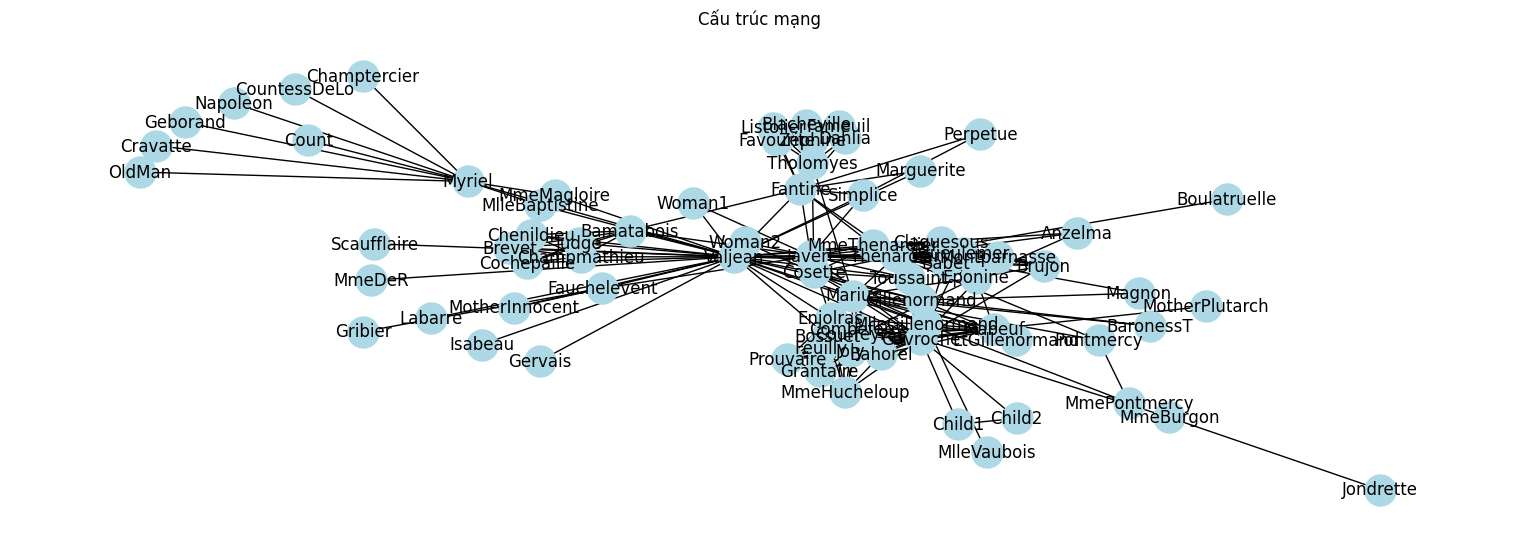

Train edges: 204
Test positive edges: 50
Test negative edges: 50

Bảng so sánh kết quả cho các phương pháp:
                    Method     AUC  Accuracy  Precision  Recall  F1-score
0         Common Neighbors  0.9286      0.81   0.746032    0.94  0.831858
1      Jaccard Coefficient  0.8924      0.81   0.746032    0.94  0.831858
2              Adamic-Adar  0.9348      0.81   0.746032    0.94  0.831858
3  Preferential Attachment  0.8016      0.49   0.494737    0.94  0.648276


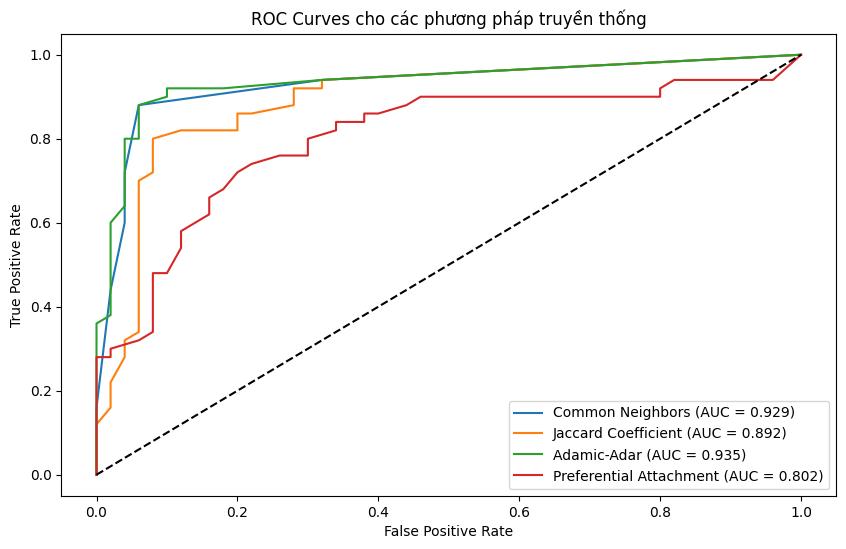


Kết quả AUC cho các phương pháp:
Common Neighbors: 0.929
Jaccard Coefficient: 0.892
Adamic-Adar: 0.935
Preferential Attachment: 0.802

Bảng kết quả mở rộng với Random Forest:
                    Method       AUC  Accuracy  Precision    Recall  F1-score
0         Common Neighbors  0.928600      0.81   0.746032  0.940000  0.831858
1      Jaccard Coefficient  0.892400      0.81   0.746032  0.940000  0.831858
2              Adamic-Adar  0.934800      0.81   0.746032  0.940000  0.831858
3  Preferential Attachment  0.801600      0.49   0.494737  0.940000  0.648276
4            Random Forest  0.947964      0.90   0.937500  0.882353  0.909091


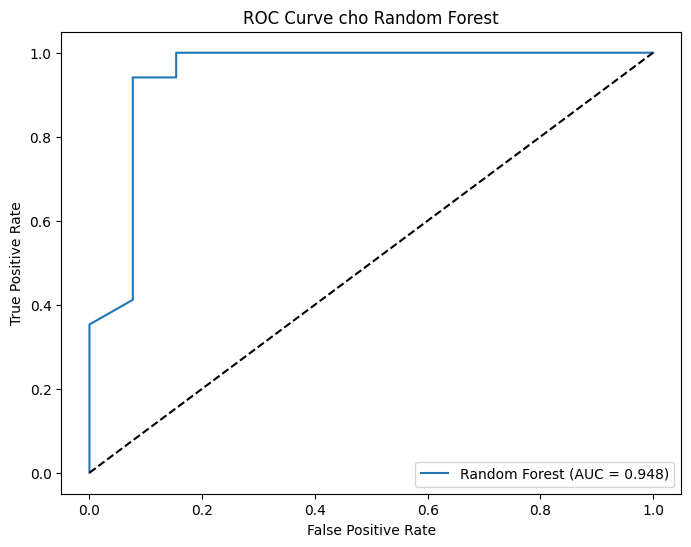

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

class LinkPrediction:
    def __init__(self, dataset='karate'):
        """
        Khởi tạo với dataset đã cho.

        Parameters:
            dataset (str): Tên dataset ('karate', 'les', 'florentine')
        """
        if dataset == 'karate':
            self.G = nx.karate_club_graph()
        elif dataset == 'les':
            self.G = nx.les_miserables_graph()
        elif dataset == 'florentine':
            self.G = nx.florentine_families_graph()
        else:
            raise ValueError("Dataset không hợp lệ")

    def analyze_network(self):
        """Phân tích cơ bản về mạng."""
        print("\n=== Phân tích mạng ===")
        print(f"Số node: {self.G.number_of_nodes()}")
        print(f"Số cạnh: {self.G.number_of_edges()}")
        print(f"Clustering trung bình: {nx.average_clustering(self.G):.3f}")

        plt.figure(figsize=(15, 5))
        pos = nx.spring_layout(self.G, seed=42)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', node_size=500)
        plt.title("Cấu trúc mạng")
        plt.show()

    def prepare_data(self):
        """Chuẩn bị dữ liệu train và test."""
        edges = list(self.G.edges())
        np.random.seed(42)
        np.random.shuffle(edges)

        n_test = int(len(edges) * 0.2)
        self.test_edges = edges[:n_test]
        self.train_edges = edges[n_test:]

        self.train_G = self.G.copy()
        self.train_G.remove_edges_from(self.test_edges)

        non_edges = list(nx.non_edges(self.train_G))
        np.random.shuffle(non_edges)
        self.test_non_edges = non_edges[:n_test]
        print(f"Train edges: {len(self.train_edges)}")
        print(f"Test positive edges: {len(self.test_edges)}")
        print(f"Test negative edges: {len(self.test_non_edges)}")

    def extract_features(self, G, u, v):
        """Trích xuất features cho các node pairs."""
        cn = len(list(nx.common_neighbors(G, u, v)))
        jc = list(nx.jaccard_coefficient(G, [(u, v)]))[0][2]
        aa = list(nx.adamic_adar_index(G, [(u, v)]))[0][2]
        pa = list(nx.preferential_attachment(G, [(u, v)]))[0][2]
        return [cn, jc, aa, pa]

    def prepare_ml_data(self, G, positive_edges, negative_edges):
        """Tạo dữ liệu cho machine learning."""
        X = [self.extract_features(G, u, v) for u, v in positive_edges + negative_edges]
        y = [1] * len(positive_edges) + [0] * len(negative_edges)
        return np.array(X), np.array(y)

    def evaluate_ml(self):
        """Huấn luyện mô hình ML và đánh giá."""
        X, y = self.prepare_ml_data(self.train_G, self.test_edges, self.test_non_edges)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        # Tính các metric
        auc = roc_auc_score(y_test, y_pred_proba)
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Tạo DataFrame mới cho Random Forest
        rf_results = pd.DataFrame([{
            "Method": "Random Forest",
            "AUC": auc,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }])

        # Concatenate với kết quả cũ
        self.results_df = pd.concat([self.results_df, rf_results], ignore_index=True)

        # Hiển thị bảng kết quả
        print("\nBảng kết quả mở rộng với Random Forest:")
        print(self.results_df)

        # Vẽ ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc:.3f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve cho Random Forest')
        plt.legend()
        plt.show()


    def evaluate_baselines(self):
        """Đánh giá các phương pháp truyền thống."""
        methods = {
            'Common Neighbors': lambda u, v: len(list(nx.common_neighbors(self.train_G, u, v))),
            'Jaccard Coefficient': lambda u, v: list(nx.jaccard_coefficient(self.train_G, [(u, v)]))[0][2],
            'Adamic-Adar': lambda u, v: list(nx.adamic_adar_index(self.train_G, [(u, v)]))[0][2],
            'Preferential Attachment': lambda u, v: list(nx.preferential_attachment(self.train_G, [(u, v)]))[0][2],
        }

        results = []

        for name, score_func in methods.items():
            # Tính điểm cho positive và negative edges
            pos_scores = [score_func(u, v) for u, v in self.test_edges]
            neg_scores = [score_func(u, v) for u, v in self.test_non_edges]

            # Tạo y_true và y_scores
            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores
            y_pred = [1 if score > 0 else 0 for score in y_scores]  # Dự đoán nhị phân

            # Tính các metric
            auc = roc_auc_score(y_true, y_scores)
            acc = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)

            # Lưu kết quả
            results.append({
                "Method": name,
                "AUC": auc,
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1-score": f1
            })

        # Chuyển kết quả thành DataFrame
        self.results_df = pd.DataFrame(results)
        print("\nBảng so sánh kết quả cho các phương pháp:")
        print(self.results_df)

        # Vẽ ROC Curves
        plt.figure(figsize=(10, 6))
        for name, score_func in methods.items():
            pos_scores = [score_func(u, v) for u, v in self.test_edges]
            neg_scores = [score_func(u, v) for u, v in self.test_non_edges]

            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores
            fpr, tpr, _ = roc_curve(y_true, y_scores)

            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_true, y_scores):.3f})")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves cho các phương pháp truyền thống')
        plt.legend()
        plt.show()

        print("\nKết quả AUC cho các phương pháp:")
        # Sử dụng results_df thay vì results để in kết quả AUC
        for _, row in self.results_df.iterrows():
            print(f"{row['Method']}: {row['AUC']:.3f}")

    def run_experiment(self):
        """Chạy thử nghiệm hoàn chỉnh."""
        self.analyze_network()
        self.prepare_data()
        self.evaluate_baselines()
        self.evaluate_ml()

if __name__ == "__main__":
    print("Chọn dataset:")
    print("1. Zachary's Karate Club")
    print("2. Les Miserables Network")
    print("3. Florentine Families Network")
    choice = input("Nhập lựa chọn (1-3): ")
    datasets = {'1': 'karate', '2': 'les', '3': 'florentine'}

    if choice in datasets:
        lp = LinkPrediction(dataset=datasets[choice])
        lp.run_experiment()
    else:
        print("Lựa chọn không hợp lệ!")
